## Distributed Prioritised Experience Replay (Ape-X)
This notebook outlines an implementation of [DeepMind’s Ape-X algorithm](https://arxiv.org/abs/1803.00933), an advanced distributed reinforcement learning extension to DQN. 

### Distributed Reinforcement Learning
Distributed reinforcement learning splits training across multiple cores or machines, significantly accelerating learning and allowing for the scaling up of capabilities by parallelising data collection and computation.

### Ape-X
Ape-X separates acting from learning. Actors interact with their own instances of the environment using a copy of a shared neural network, sendhing their collected experiences to a shared replay buffer. The learner then samples these experiences to update the network. Ape-X substantially improved upon the state of the art at the time, achieiving far greater performance than any previous comparable algorithms in a fraction of the training time.

This implementation utilises [ZeroMQ](https://zeromq.org/) for inter-process communication and [Ray](https://www.ray.io/) for asynchronous task management. Below is an overview of the system:

<img src="https://i.imgur.com/JQofKZU.png" 
     align="center" 
     width="700"
     style="padding: 20px;" />

#### Actor
Actors operate independently, each in its own environment, generating experiences that are sent to the replay buffer via a push socket. They receive updated network parameters from the learner through a subscribe socket, updating their networks, and continuing to gather new experiences.

#### Learner
The learner periodically requests experience batches from the replay buffer through a request socket to update the network. It then sends back updated priorities to the replay buffer via a reply socket and distributes the latest network parameters to the actors using a publish socket, ensuring all actors are using recent model weights.

#### Replay
This process receives experiences from actors via a pull socket and stores them in a prioritised global replay buffer. It serves the learner by sending prioritised experiences for learning upon request through a request socket. Once the learner updates these experiences, the replay process updates their priorities based on feedback received via a reply socket.

### Ape-X DQN
Ape-X can be described as a DQN variant with some components of Rainbow, notably double DQN, multi-step bootstrap targets and the dueling architecture, along with a modified PER buffer that accepts an initial priority with added experiences. We also include global gradient clipping, soft target network updates, and the option to perform multiple learning updates on each batch of data.

### Ape-X Exploration Strategy
For methods in the DQN family, $\epsilon$-greedy remains the most popular exploration strategy, where with probability $\epsilon$, we select a random action, otherwise we select the best action (greedy action selection). Typically, epsilon starts at a higher value which is then gradually decayed/annealed. In Ape-X, each actor has its own $\epsilon$, which is kept constant throughout the training, meaning some actors will function more as explorers, and others more as exploiters.

In the original paper, each actor $i \in \{0, ..., N - 1\}$ follows an $\epsilon_i$-greedy policy, where $\epsilon_i = \epsilon^{1 + \alpha \frac{i}{N - 1}}$ with $\epsilon = 0.4$ and $\alpha = 7$. We follow this in our implementation with slightly different parameters due to resource limitations.

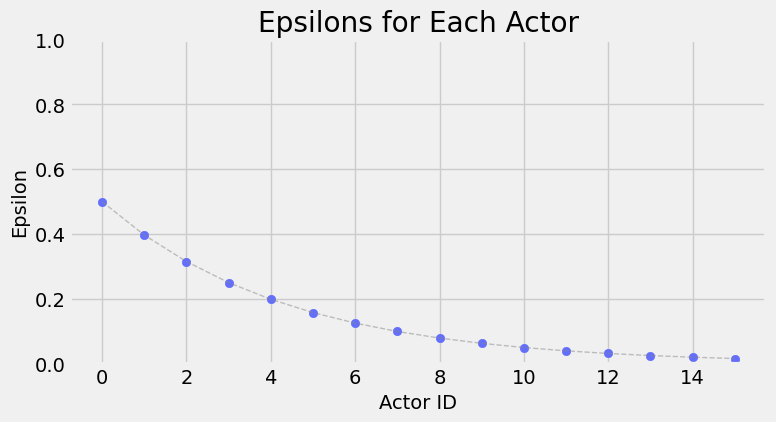

In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

num_actors = 16
epsilon = 0.5
alpha = 5
epsilon_values = [epsilon ** (1 + (alpha * (i / (num_actors - 1)))) for i in range(num_actors)]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(epsilon_values, lw=1, ls='--', c='#888888', alpha=0.5)
ax.scatter(range(num_actors), epsilon_values, c='#636EFA')
ax.set_title('Epsilons for Each Actor')
ax.set_xlabel('Actor ID')
ax.set_ylabel('Epsilon')
ax.set_ylim([0, 1])

plt.show()

## DQN Q-Networks
PyTorch implementations of a simple deep Q-network and dueling variant.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)            
        )
        
    def forward(self, x):
        return self.network(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.value = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.advantage = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, x):
        x = self.base(x)
        value = self.value(x)
        advantages = self.advantage(x)

        # Combine value and advantages to get final Q-values
        # Using the formula: Q(s, a) = V(s) + (A(s, a) - mean(A(s, a)))
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values
    


## Prioritised Experience Replay Buffer

### Segment Trees
[OpenAI's segment tree implementation]((https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py)) is used as the data structure to manage priority in our prioritised experience replay buffer as they allow retrieval, sum, max and min to be performed in $O(\log n)$ time complexity.

### PER Buffer
Largely similar to [OpenAI's prioritised experience replay buffer implementation](https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py), but modified for Ape-X by allowing a precomputed priority to be included when adding experiences to buffer, along with some refactoring and renaming.

In [3]:
import operator

class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        assert capacity > 0 and capacity & (capacity - 1) == 0, "Capacity must be a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )
            
    def reduce(self, start=0, end=None):
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation( self._value[2 * idx], self._value[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]

class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super().__init__(capacity=capacity, operation=operator.add, neutral_element=0.0)

    def sum(self, start=0, end=None):
        return super().reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity

class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super().__init__(capacity=capacity, operation=min, neutral_element=float('inf'))

    def min(self, start=0, end=None):
        return super().reduce(start, end)
    
import numpy as np
import random

class PriorityBuffer:
    def __init__(self, size, alpha, beta):
        self.max_size = size
        self.alpha = alpha
        self.beta = beta
        
        # Replay buffer storage
        self.storage = []
        self.next_idx = 0
        
        # Segment trees to manage priority
        tree_size = 1
        while tree_size <= size:
            tree_size *= 2
        self.sum_tree = SumSegmentTree(tree_size)
        self.min_tree = MinSegmentTree(tree_size)
        self.max_priority = 1.
        
    def select_indices_by_priority(self, batch_size):
        "Select indices weighted by their relative priority."
        indices = []
        total_priority = self.sum_tree.sum(0, len(self.storage) - 1)
        segment_size = total_priority / batch_size
        for segment_idx in range(batch_size):
            mass = random.random() * segment_size + segment_idx * segment_size
            idx = self.sum_tree.find_prefixsum_idx(mass)
            indices.append(idx)
        return indices
    
    def calculate_importance_weights(self, indices):
        "Calculates importance weights which we scale losses for each sample by."
        weights = []
        min_priority = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (min_priority * len(self.storage)) ** (-self.beta)
        for idx in indices:
            priority = self.sum_tree[idx] / self.sum_tree.sum()
            weight = (priority * len(self.storage)) ** (-self.beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        return weights
    
    def collect_experiences(self, indices):
        "Unpacks experiences into numpy arrays."
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for idx in indices:
            experience = self.storage[idx]
            state, action, reward, next_state, done = experience
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
            
    def add(self, experience, priority=None):
        "Add an experience tuple to replay buffer."
        priority = priority if priority is not None else self.max_priority
        self.sum_tree[self.next_idx] = priority ** self.alpha
        self.min_tree[self.next_idx] = priority ** self.alpha
        
        if self.next_idx == len(self.storage):
            self.storage.append(experience)
        else:
            self.storage[self.next_idx] = experience
        self.next_idx = (self.next_idx + 1) % self.max_size
        
    def sample(self, batch_size):
        "Sample from replay buffer."
        indices = self.select_indices_by_priority(batch_size)
        weights = self.calculate_importance_weights(indices)
        experiences = self.collect_experiences(indices)
        return (experiences, indices, weights)
        
    def update_priorities(self, indices, priorities):
        "Updates priorities at provided indices based on observed td-error."
        assert len(indices) == len(priorities), "Priorities and indices have different lengths."
        for idx, priority in zip(indices, priorities):
            assert priority > 0, "Provided priority must be >= 0."
            assert 0 <= idx < len(self.storage), "Provided index out of bounds."
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.storage)

## Global Buffer
The Global Buffer functions as a distributed wrapper to the PER buffer, coordinating the receiving of new experiences from actors and the delivery of experience batches to the learner. We also use the global buffer to coordinate training, by receiving information from the connected learner and actors, it is able to publish instructions to update the training protocol.

In [4]:
import ray
import zmq
import time

@ray.remote
class GlobalBuffer:
    "Serves as a distributed replay buffer, also manages logs and sending of commands to other entities."
    def __init__(self, config):
        self.logs = {'updates': 0, 'steps': 0, 'rewards': [], 'dones': 0, 'start_time': time.time()}
        self.buffer = PriorityBuffer(config['per_buffer_capacity'], config['per_buffer_alpha'], 
                                     config['per_buffer_beta'])
        self.batch_size = config['batch_size']
        self.initialize_sockets(config['repreq_port'], config['pushpull_port'], config['pubsub_port_2'])
        self.config = config
            
    def initialize_sockets(self, repreq_port, pushpull_port, pubsub_port):
        "Initialise ZMQ sockets used for inter-process communication."
        context = zmq.Context()
        
        # Used to send a batch of experiences to learner and receives updated priorities as a reply
        self.req_socket = context.socket(zmq.REQ)
        self.req_socket.connect(f"tcp://127.0.0.1:{repreq_port}")
        
        # Used to receive experiences from actors to add to global buffer
        self.pull_socket = context.socket(zmq.PULL)
        self.pull_socket.set_hwm(256)  # High watermark for socket receive buffer
        self.pull_socket.bind(f"tcp://127.0.0.1:{pushpull_port}")
        
        # Used to send instructions to learner and actors
        self.pub_socket = context.socket(zmq.PUB)
        self.pub_socket.bind(f"tcp://127.0.0.1:{pubsub_port}")
        
    def receive_priorities(self):
        "Receives updated priorities over req socket."
        try:
            indices, new_priorities = self.req_socket.recv_pyobj(zmq.DONTWAIT)
            return indices, new_priorities
        except zmq.Again:
            return None, None
        
    def receive_new_experiences_and_logs(self):
        "Attempt to receive a list of experience tuples and corresponding logs from an actor."
        try:
            new_experiences, logs = self.pull_socket.recv_pyobj(zmq.DONTWAIT)
            return new_experiences, logs
        except zmq.Again:
            return None, None
        
    def send_batch(self, experience_batch):
        "Sends a batch of experiences to learner over req socket."
        self.req_socket.send_pyobj(experience_batch, protocol=5)
        
    def send_instruction(self, instruction):
        "Sends an instruction to connected sub sockets."
        self.pub_socket.send_pyobj(instruction, protocol=5)
        
    def select_instruction(self):
        "Logic to decide on what instruction to send to learner and actors."
        if self.logs['steps'] >= self.config['total_steps']:
            return 'stop'
        if self.config['target_reward'] and len(self.logs['rewards']) > 0:
            if np.mean(self.logs['rewards'][-20:]) >= self.config['target_reward']:
                return 'stop'
        return None
    
    def process_logs(self, new_logs):
        "Updates logs with new information."
        if new_logs:
            if 'steps' in new_logs.keys():
                self.logs['steps'] += new_logs['steps']
            if 'rewards' in new_logs.keys():
                self.logs['rewards'] += new_logs['rewards']
            if 'dones' in new_logs.keys():
                self.logs['dones'] += new_logs['dones']
                
    def get_logs(self):
        "Used to retrieve logs at the end of training."
        return self.logs
    
    def sample_batch(self):
        "Samples a batch of experiences from the PER buffer."
        experiences = self.buffer.sample(self.batch_size)
        return experiences
    
    def remove_old_priorities(self, indices, new_priorities, start_idx, end_idx):
        "Removes any overwritten priorities and indices that were sampled."
        indices_array = np.array(indices)
        valid_mask = (indices_array < start_idx) | (indices_array >= end_idx)
        return indices_array[valid_mask].tolist(), new_priorities[valid_mask]
    
    def fill_buffer(self):
        "Fill up the replay buffer with enough experiences that the learner can begin sampling from it."
        while len(self.buffer) < self.batch_size or len(self.buffer) < self.config['learning_starts']:
            new_experiences, new_logs = self.receive_new_experiences_and_logs()
            if new_experiences:
                self.process_logs(new_logs)
                for experience, priority in new_experiences:
                    self.buffer.add(experience, priority)
    
    def run(self):
        "Global buffer main process."
        # Fill buffer so learner can begin learning
        self.fill_buffer()
        awaiting_priorities = False
        while True:
            
            # If not waiting for priorities, sample a batch and send to learner
            if not awaiting_priorities:
                experience_batch = self.sample_batch()
                self.send_batch(experience_batch)
                start_idx = self.buffer.next_idx
                awaiting_priorities = True

            # If waiting for priorities, attempt to receive them without blocking
            if awaiting_priorities:
                indices, new_priorities = self.receive_priorities()

                # If received, update priorities and prepare to sample new batch
                if new_priorities is not None:
                    end_idx = self.buffer.next_idx
                    indices, new_priorities = self.remove_old_priorities(indices, new_priorities, start_idx, end_idx)
                    self.buffer.update_priorities(indices, new_priorities)
                    self.logs['updates'] += 1
                    awaiting_priorities = False
            
            # Attempt to receive new experiences from actors and process logs
            new_experiences, new_logs = self.receive_new_experiences_and_logs()
            if new_experiences:
                self.process_logs(new_logs)
                for experience, priority in new_experiences:
                    self.buffer.add(experience, priority)
            
            # Will generate an instruction to send to other entities
            instruction = self.select_instruction()
            if instruction is not None:
                self.send_instruction(instruction)
                if instruction == 'stop':
                    self.logs['end_time'] = time.time()
                    self.logs['elapsed_time'] = self.logs['end_time'] - self.logs['start_time']
                    break

## Actor
Each Actor interacts with its own environment, generating experiences and sending them to a global buffer.

### Local Buffer
A small local buffer used to handle the creation of n-step experience tuples.

In [5]:
import numpy as np
import gymnasium as gym
import random
import torch
import ray
import zmq
import copy
import time

@ray.remote
class Actor:
    "Performs rollouts in local environment, sending experiences to global replay buffer."
    def __init__(self, idx, network, env, config):
        self.idx = idx
        self.device = config['actor_device']
        self.network = copy.deepcopy(network).to(self.device)
        self.env = env
        self.local_buffer = LocalBuffer(config['num_steps'], config['gamma'])
        self.epsilon = config['epsilon_max'] ** ((1 + config['epsilon_alpha'] * self.idx / (config['num_actors'] - 1)))
        self.initialize_sockets(config['pubsub_port'], config['pushpull_port'], config['pubsub_port_2'])
        self.config = config
        
    def initialize_sockets(self, pubsub_port, pushpull_port, pubsub_port_2):
        "Initialise ZMQ sockets used for inter-process communication."
        context = zmq.Context()
        # This socket is used to receive new model parameters from learner
        self.sub_socket = context.socket(zmq.SUB) 
        self.sub_socket.setsockopt_string(zmq.SUBSCRIBE, '')  # Accept all messages sent by publisher
        self.sub_socket.setsockopt(zmq.CONFLATE, 1)           # Keep only most recent message received
        self.sub_socket.connect(f"tcp://127.0.0.1:{pubsub_port}")
        
        # Sends gathered experiences from actor to global buffer
        self.push_socket = context.socket(zmq.PUSH)
        self.push_socket.set_hwm(16)  # Max messages that can be queued to socket's send buffer
        self.push_socket.connect(f"tcp://127.0.0.1:{pushpull_port}")
        
        # Receives instructions from the global buffer
        self.sub_socket_2 = context.socket(zmq.SUB)
        self.sub_socket_2.setsockopt_string(zmq.SUBSCRIBE, '')
        self.sub_socket_2.setsockopt(zmq.CONFLATE, 1)
        self.sub_socket_2.connect(f"tcp://127.0.0.1:{pubsub_port_2}")
        
    def receive_new_parameters(self):
        "Attempts to receive updated parameters from learner without blocking."
        try:
            new_parameters = self.sub_socket.recv_pyobj(zmq.DONTWAIT)
            return new_parameters
        except zmq.Again:
            return None
        
    def receive_instruction(self):
        "Attempts to receive instructions sent from global buffer."
        try:
            instruction = self.sub_socket_2.recv_pyobj(zmq.DONTWAIT)
            return instruction
        except zmq.Again:
            return None
        
    def send_experiences_and_logs(self, experiences, logs):
        "Send local gathered experiences andlogs to global buffer."
        self.push_socket.send_pyobj((experiences, logs), protocol=5)
        
    def update_actor_parameters(self, new_parameters):
        "Update actor network parameters with newly received ones."
        for param, new_param in zip(self.network.parameters(), new_parameters):
            new_param = torch.tensor(new_param, dtype=torch.float32, device=self.device)
            param.data.copy_(new_param)
    
    def calculate_initial_priority(self, experience):
        "Calculates initial priority for an experience."
        state, action, reward, next_state, done = experience
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            current_state_q = self.network(state_tensor).squeeze(0)[action].item()
            next_state_q = self.network(next_state_tensor).squeeze(0).max().item()

        # Calculate td-error with N-step Bellman equation
        target_q = reward + self.config['gamma'] ** self.config['num_steps'] * next_state_q * (1. - done)
        td_error = np.abs(current_state_q - target_q)
        priority = np.clip(td_error, a_min=1e-6, a_max=np.inf)
        return priority
    
    def select_action(self, state):
        "Action selection with epsilon-greedy."
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        return self.network(state_tensor).unsqueeze(0).argmax().item()
    
    def rollout(self):
        "Performs a rollout in environment gathering experiences until done or maximum steps reached."
        # N-step experience tuples stored in here
        experiences = []
        
        # Tracking
        episode_logs = {'step': 0, 'reward': 0., 'done': False}
        
        # Reset environment and begin rollout
        state, _ = self.env.reset()
        terminated, truncated = False, False
        while not (terminated or truncated):
            # Select action, step in environment and add to local buffer
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            self.local_buffer.add((state, action, reward, next_state, terminated))
            
            # If n-step buffer is full, add experience to buffer
            if len(self.local_buffer) == self.config['num_steps']:
                experience = self.local_buffer.sample()
                priority = self.calculate_initial_priority(experience)
                experiences.append((experience, priority))
            state = next_state
            
            # Tracking and episode step limit
            episode_logs['step'] += 1
            episode_logs['reward'] += reward
            if self.config['max_episode_steps'] and episode_logs['step'] <= self.config['max_episode_steps']:
                truncated = True
            episode_logs['done'] = terminated or truncated
            
        # Clear to prepare for next episode
        self.local_buffer.clear()
        return experiences, episode_logs
    
    def collect_experiences(self):
        "Performs rollouts collecting experiences until actor buffer is at max capacity."
        experiences = []
        logs = {'actor_idx': self.idx, 'steps': 0, 'rewards': [], 'dones': 0}
        while len(experiences) < self.config['actor_buffer_capacity']:
            episode_experiences, episode_logs = self.rollout()
            experiences += episode_experiences
            logs['steps'] += episode_logs['step']
            logs['rewards'] += [episode_logs['reward']]
            logs['dones'] += int(episode_logs['done'])
        return experiences, logs
        
    def run(self):
        "Actor main process."
        while True:
            # Gather experiences in environment and send to global buffer
            experiences, logs = self.collect_experiences()
            self.send_experiences_and_logs(experiences, logs)
            
            # Attempt to receive new parameters from learner
            new_parameters = self.receive_new_parameters()
            if new_parameters:
                self.update_actor_parameters(new_parameters)
                
            # Attempt to receive instructions from global buffer
            instruction = self.receive_instruction()
            if instruction:
                if instruction == 'stop':
                    break
                    
from collections import deque

### Local Buffer ###
class LocalBuffer:
    def __init__(self, num_steps, gamma):
        self.buffer = deque(maxlen=num_steps)
        self.gamma = gamma
        
    def add(self, transition):
        "Accepts a single transition (s, a, r, s', ter)."
        self.buffer.append(transition)
    
    def sample(self):
        "Returns an n-step experience tuple."
        discounted_reward = 0.
        for transition in reversed(self.buffer):
            state, action, reward, _, _ = transition
            discounted_reward = self.gamma * discounted_reward + reward
        _, _, _, final_state, done = self.buffer[-1]
        return (state, action, discounted_reward, final_state, done)
    
    def clear(self):
        "Clears all transitions from buffer."
        self.buffer.clear()
    
    def __len__(self):
        return len(self.buffer)

## Learner
The Learner updates the Q-network using experiences sampled from a global buffer, and periodically sends updated network parameters back to the actors. It also adjusts the priority of experiences in the buffer based on the observed TD error.

In [6]:
import numpy as np
import random
import torch
import ray
import zmq
import copy
import time
from collections import deque

@ray.remote #(num_gpus=1)
class Learner:
    "Learner continually samples experiences from global replay buffer and performs learning updates."
    def __init__(self, network, config):
        self.device = config['learner_device']
        self.online_network = copy.deepcopy(network).to(self.device)
        self.target_network = copy.deepcopy(network).to(self.device)
        self.optimizer = torch.optim.RMSprop(
            self.online_network.parameters(), lr=config['lr'], alpha=config['optim_alpha'], 
            eps=config['optim_eps'], momentum=config['optim_momentum'], centered=config['optim_centered']
        )
        self.initialize_sockets(config['pubsub_port'], config['repreq_port'], config['pubsub_port_2'])
        self.config = config
        
    def initialize_sockets(self, pubsub_port, repreq_port, pubsub_port_2):
        "Initialise ZMQ sockets used for inter-process communication."
        context = zmq.Context()
        # This socket is used to periodically send updated network parameters to actors
        self.pub_socket = context.socket(zmq.PUB)
        self.pub_socket.bind(f"tcp://127.0.0.1:{pubsub_port}")

        # New priorities are sent as a reply to the global buffer after being sent a batch of experiences
        self.rep_socket = context.socket(zmq.REP)
        self.rep_socket.setsockopt(zmq.RCVTIMEO, 1000)
        self.rep_socket.bind(f"tcp://127.0.0.1:{repreq_port}")
        
        # Receives instructions from the controller
        self.sub_socket_2 = context.socket(zmq.SUB)
        self.sub_socket_2.setsockopt_string(zmq.SUBSCRIBE, '')
        self.sub_socket_2.setsockopt(zmq.CONFLATE, 1)
        self.sub_socket_2.connect(f"tcp://127.0.0.1:{pubsub_port_2}")
        
    def receive_experiences(self):
        "Receives new batch of experiences from global buffer and appends to experience queue."
        try:
            experiences = self.rep_socket.recv_pyobj()
            return experiences
        except zmq.Again:
            return None
        
    def receive_instruction(self):
        "Attempt to receive instructions sent to sub socket 2."
        try:
            instruction = self.sub_socket_2.recv_pyobj(zmq.DONTWAIT)
            return instruction
        except zmq.Again:
            return None    
        
    def publish_parameters(self, parameters):
        "Send network parameters to actors."
        self.pub_socket.send_pyobj(parameters, protocol=5)
        
    def send_new_priorities(self, indices, priorities):
        "Send new priorities and indices to global buffer reqrep socket."
        self.rep_socket.send_pyobj((indices, priorities), protocol=5)
    
    def get_parameters(self):
        "Returns online network parameters converted to a list of numpy arrays."
        model = copy.deepcopy(self.online_network)
        state_dict = model.cpu().state_dict()
        parameters = [param.numpy() for param in state_dict.values()]
        return parameters
        
    def update_target_network(self, tau):
        "Updates the parameters of the target network, tau controls how fully the weights are copied."
        with torch.no_grad():
            for target_param, online_param in zip(self.target_network.parameters(), self.online_network.parameters()):
                target_param.data.copy_(tau * online_param.data + (1. - tau) * target_param.data)
    
    def learn(self, data):
        "Perform a single learning step."
        # Expand experience data and convert to tensors
        experiences, indices, weights = data
        states, actions, rewards, next_states, dones = experiences
        states      = torch.tensor(states,      dtype=torch.float32, device=self.device)
        actions     = torch.tensor(actions,     dtype=torch.int64,   device=self.device).unsqueeze(1)
        rewards     = torch.tensor(rewards,     dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones       = torch.tensor(dones,       dtype=torch.float32, device=self.device).unsqueeze(1)
        weights     = torch.tensor(weights,     dtype=torch.float32, device=self.device).unsqueeze(1)
        
        # Predicted Q-values for current state
        current_state_q = self.online_network(states)
        
        # Gather Q-values of actions actually taken
        current_action_q = torch.gather(current_state_q, dim=1, index=actions)
        
        # Calculate target
        with torch.no_grad():
            # Boostrap from target network
            next_state_q = self.target_network(next_states)
            
            if self.config['double_dqn']:
                # Select action index from target network based on greatest state-action value from online network
                next_state_best_actions = torch.argmax(self.online_network(next_states), dim=1, keepdims=True)
                next_state_max_q = torch.gather(next_state_q, dim=1, index=next_state_best_actions)
            else:
                # Select action index based on greatest state-action value from target network
                next_state_max_q = torch.max(next_state_q, dim=1, keepdims=True)[0]
            
            # Unrolled Bellman equation to compute target Q-values
            target_q = rewards + self.config['gamma'] ** self.config['num_steps'] * (1. - dones) * next_state_max_q
        
        # Weighted loss calculation with MSE
        td_error = (current_action_q - target_q)
        loss = (td_error.pow(2) * weights).mean()
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.online_network.parameters(), self.config['grad_norm_clip'])
        self.optimizer.step()
        
        # Return indices and new priorities
        new_priorities = np.clip(td_error.detach().abs().squeeze(1).cpu().numpy(), a_min=1e-6, a_max=np.inf)
        return indices, new_priorities
    
    def run(self):
        "Learner main process."
        update_count = 0
        while True:
            # Receive new experiences with 1 second timeout
            experience_data = self.receive_experiences()
            
            # If experience data was received perform learning step(s) and update priorities
            if experience_data is not None:
                indices, new_priorities = self.learn(experience_data)
                self.send_new_priorities(indices, new_priorities)
                update_count += 1
                
                # Periodically publish parameters
                if update_count % self.config['parameter_publish_interval'] == 0:
                    parameters = self.get_parameters()
                    self.publish_parameters(parameters)
                
                # Periodically update target network
                if update_count % self.config['target_update_frequency'] == 0:
                    self.update_target_network(self.config['tau'])
                
            # Attempt to receive instructions from global buffer
            instruction = self.receive_instruction()
            if instruction:
                if instruction == 'stop':
                    break

## Ape-X
The ApeX class orchestrates the setup and training of the system, spawning actors and a learner with their respective environments with a copy of the learner's network. It also initialises a global buffer and triggers the `run()` method for all entities using Ray for distributed execution.

In [7]:
class ApeX:
    def __init__(self, actor_class, learner_class, network_class, global_buffer_class, config):
        self.actor_class = actor_class
        self.learner_class = learner_class
        self.network_class = network_class
        self.global_buffer_class = global_buffer_class
        self.config = config
    
    def spawn(self):
        "Spawns all entities."
        environments = [gym.make(self.config['env_name']) for _ in range(self.config['num_actors'])]
        network = self.network_class(np.prod(environments[0].observation_space.shape), environments[0].action_space.n, self.config['hidden_dim'])
        self.actors = [self.actor_class.remote(idx, network, env, self.config) for idx, env in enumerate(environments)]
        self.learner = self.learner_class.remote(network, self.config)
        self.global_buffer = self.global_buffer_class.remote(self.config)
    
    def train(self):
        "Train model according to configuration."
        print('Training started')
        ray.init()
        try:
            self.spawn()
            ray.wait([process.run.remote() for process in self.actors + [self.learner] + [self.global_buffer]])
            self.logs = ray.get(self.global_buffer.get_logs.remote())
        finally:
            ray.shutdown()
        print('Training ended')

## Ape-X Config

In [8]:
apex_config = {
    'env_name'                  : 'CartPole-v1',  # Environment name
    'num_actors'                :       8,  # Number of distributed actors
    'actor_device'              :   'cpu',  # Device that actors run on
    'learner_device'            :   'cpu',  # Device learner runs on
    'total_steps'               : 1000000,  # Total training steps
    'target_reward'             :     195,  # Target reward to stop training at when reached
    'num_steps'                 :       3,  # Number of steps to unroll Bellman equation by
    'max_episode_steps'         :    None,  # Rollouts limited to this many steps (50k in OP)
    'epsilon_max'               :     0.5,  # Maximum e-greedy epsilon value
    'epsilon_alpha'             :       5,  # Steepness of epsilon values curve
    'gamma'                     :    0.99,  # Discount Factor 
    'lr'                        :  2.5e-4,  # Learning rate
    'optim_alpha'               :    0.95,  # Decay rate affecting how much weight given to past gradients
    'optim_eps'                 :  1.5e-7,  # Small number added to update eqn denominator for stability
    'optim_momentum'            :      0.,  # Gradient momentum weight
    'optim_centered'            :    True,  # Update weights with variance normalised gradients
    'batch_size'                :     256,  # Batch size used by learner
    'learning_starts'           :   20000,  # Number of transitions accumulated in replay buffer before learning
    'parameter_publish_interval':      10,  # Publish new parameters every interval number of learning updates (400 in OP)
    'dueling'                   :    True,  # Dueling networks tweak
    'double_dqn'                :    True,  # Double DQN tweak
    'hidden_dim'                :      64,  # Number of neurons in hidden layers
    'target_update_frequency'   :       1,  # How many learning steps per target network update (2500 used in OP)
    'tau'                       :    0.01,  # Soft target network update interpolation coefficient (1. used in OP)
    'grad_norm_clip'            :      40,  # Global gradient clipping value
    'per_buffer_capacity'       :  100000,  # Prioritised experience replay buffer maximum capacity (2m in OP)
    'per_buffer_alpha'          :     0.6,  # Priority sampling weight (0 for maximum sampling entropy)
    'per_buffer_beta'           :     0.4,  # Importance sampling correction to reduce bias from frequently sampled experiences
    'actor_buffer_capacity'     :    1000,  # Each actor will accumulate this many experience tuples before sending them to PER buffer
    'pubsub_port'               :    5560,  # Pubsub port for publishing new parameters
    'repreq_port'               :    5561,  # Repreq for sending experience batches and priorities
    'pushpull_port'             :    5562,  # Used to send actor experiences to global buffer
    'pubsub_port_2'             :    5563,  # Used to send logs from actor and learner to global buffer
}

## Train Ape-X Agent

In [9]:
apex = ApeX(Actor, Learner, DuelingQNetwork, GlobalBuffer, apex_config)
apex.train()
logs = apex.logs

Training started


2024-06-23 21:49:46,612	INFO worker.py:1749 -- Started a local Ray instance.


Training ended


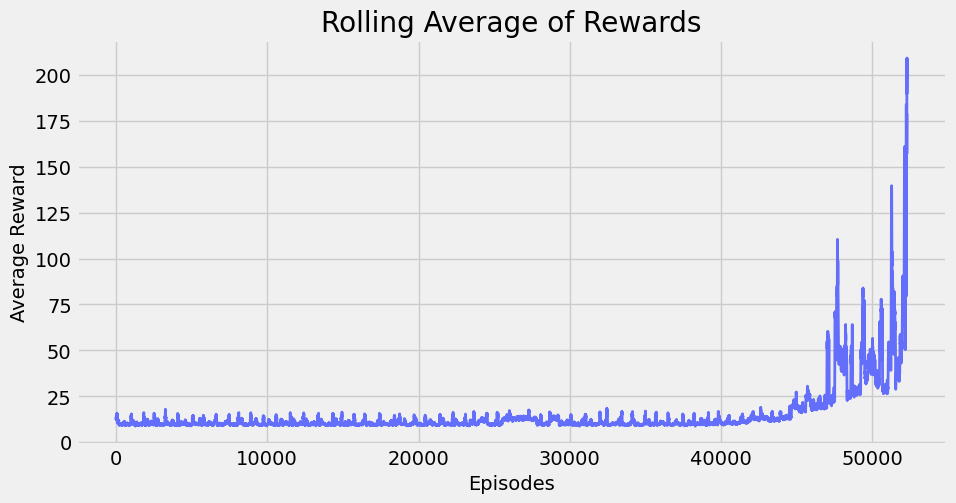

In [10]:
# Use rolling average
rewards = np.array(logs['rewards'])
window_size = 20
window = np.ones(window_size) / window_size
rolling_rewards = np.convolve(rewards, window, 'valid')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(rolling_rewards, color='#636EFA', lw=2)
plt.title('Rolling Average of Rewards')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()